## House Price Prediction


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
from matplotlib import pyplot as plt
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
import sklearn.linear_model as sklm
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn import feature_selection, preprocessing
import math
from sklearn.feature_selection import SelectPercentile,chi2, SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.svm import SVC, LinearSVC, SVR, LinearSVR
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVC, LinearSVC, SVR, LinearSVR
from sklearn.model_selection import KFold
from tqdm import tqdm
from sklearn.tree import DecisionTreeClassifier, plot_tree, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, RandomForestRegressor
from xgboost import XGBRegressor, XGBClassifier
from sklearn.preprocessing import scale 
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.model_selection import GridSearchCV

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Data Preprocessing



In [2]:
data = pd.read_csv("data.csv")
#remove the columns where more than half of values are NA
data = data.drop(columns=['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']) 
#in numeric columns replace the NAs with mean
data = data.fillna(data.mean())     
#in categorical columns replace the NAs with mode(most frequent value)            
data = data.fillna(data.mode().iloc[0])
#convert categorical columns into one-hot vectors
data_obj = data.select_dtypes(include=[object])
dummies = pd.get_dummies(data_obj)
data = data.drop(columns=data_obj.columns)
data = pd.concat([dummies, data], axis = 1)
data["SalePrice"] = data["SalePrice"].apply(np.log)

In [3]:
cor = data.corr()
#Correlation with output variable
cor_target = abs(cor["SalePrice"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]

In [4]:
X = data.loc[:, data.columns != 'SalePrice']
y = data['SalePrice']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1)

Feature Selection

In [6]:
F_vals, p_vals = feature_selection.f_regression(X_train, y_train)
def clean_pvals(entry):
    if (math.isnan(entry)):
        return 100
    else:
        return entry
clean_pvals_vectorized = np.vectorize(clean_pvals)
p_vals = clean_pvals_vectorized(p_vals)
THRESH = 1e-20

X_train_50 = X_train[X_train.columns[p_vals<THRESH]]
X_test_50 = X_test[X_train.columns[p_vals<THRESH]]

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


In [7]:
#alternative approach for feature selection
X_new = SelectKBest(f_regression, k=50).fit(X, y)
X_train_50 = X_train.iloc[:, X_new.get_support(True)]
X_test_50 = X_test.iloc[:, X_new.get_support(True)]

Lasso + Feature selection

In [8]:
alphas = 10**np.linspace(10,-2,100)*0.5

In [9]:
#best 
lassocv = LassoCV(alphas = alphas, cv = 10, max_iter = 100000, normalize = True)
lassocv.fit(X_train, y_train)

lasso = Lasso(alpha=lassocv.alpha_) #normalize = True ?
lasso.fit(X_train, y_train)
print('R-squared for train')
r2_train_lasso = lasso.score(X_train, y_train)
print(r2_train_lasso)
print('R-squared for test')
r2_test_lasso = lasso.score(X_test, y_test)
print(r2_test_lasso)
print('Mse for test')
mse_test_lasso = mean_squared_error(y_test, lasso.predict(X_test))
print(mse_test_lasso)
print('Mse for train')
mse_train_lasso = mean_squared_error(y_train, lasso.predict(X_train))
print(mean_squared_error(y_train, lasso.predict(X_train)))
print('Mae for train')
mae_train_lasso = mean_absolute_error(y_train, lasso.predict(X_train))
print(mae_train_lasso)
print("Mae for test")
mae_test_lasso = mean_absolute_error(y_test, lasso.predict(X_test))
print(mae_test_lasso)
#rmse_test_lasso = mean_squared_error(y_test, lasso.predict(X_test), squared = False)
#print(rmse_test_lasso)

R-squared for train
0.8581596112502349
R-squared for test
0.9074912644450108
Mse for test
0.014605843646528848
Mse for train
0.022465246898072357
Mae for train
0.0987297294512465
Mae for test
0.08806732492444351


In [10]:
#lasso feature selection
X_train_lasso = X_train[X_train.columns[lasso.coef_ != 0]]
X_test_lasso = X_test[X_test.columns[lasso.coef_ != 0]]

Linear Regression

In [11]:
#with all features
model_all = sklm.LinearRegression()
model_all.fit(X_train, y_train)
model_all.predict(X_test)
print("#R-squared for train")
print(model_all.score(X_train, y_train))
print("#R-squared for test")
print(model_all.score(X_test, y_test))
print("#MSE for test")
print(mean_squared_error(y_test, model_all.predict(X_test)))
print("#MSE for train")
print(mean_squared_error(y_train, model_all.predict(X_train)))

#R-squared for train
0.9489959161380479
#R-squared for test
-86188170269853.83
#MSE for test
13607914231987.508
#MSE for train
0.008078230374778495


In [12]:
#with 50 most correlated features
model1 = sklm.LinearRegression()
model1.fit(X_train_50, y_train)
model1.predict(X_test_50)
print("#R-squared for train")
print(model1.score( X_train_50, y_train))
print("#R-squared for test")
print(model1.score( X_test_50, y_test))
print("#MSE for test")
print(mean_squared_error(y_test, model1.predict(X_test_50)))
print("#MSE for train")
print(mean_squared_error(y_train, model1.predict(X_train_50)))


#R-squared for train
0.8560675665757503
#R-squared for test
0.8764443181971295
#MSE for test
0.019507724964852455
#MSE for train
0.022796593283600126


In [13]:
#best
#with features selected by Lasso
model1 = sklm.LinearRegression()
model1.fit(X_train_lasso, y_train)
y_pred_lr = model1.predict(X_test_lasso)
print("R-squared for train")
r2_train_lr = model1.score( X_train_lasso, y_train)
print(r2_train_lr)
print("R-squared for test")
r2_test_lr = model1.score( X_test_lasso, y_test)
print(r2_test_lr)
print("MSE for test")
mse_test_lr = mean_squared_error(y_test, model1.predict(X_test_lasso))
print(mse_test_lr)
print("MSE for train")
mse_train_lr = mean_squared_error(y_train, model1.predict(X_train_lasso))
print(mse_train_lr)
print('Mae for train')
mae_train_lr = mean_absolute_error(y_train, model1.predict(X_train_lasso))
print(mae_train_lr)
print("Mae for test")
mae_test_lr = mean_absolute_error(y_test, model1.predict(X_test_lasso))
print(mae_test_lr)

R-squared for train
0.8689537997140587
R-squared for test
0.9089790238689003
MSE for test
0.014370947110557265
MSE for train
0.020755620246301523
Mae for train
0.09782737987146739
Mae for test
0.09035152860149098


Ridge

In [14]:
#best
ridgecv = RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error', normalize = True)
ridgecv.fit(X_train, y_train)
ridge = Ridge(alpha = ridgecv.alpha_, normalize = True)
ridge.fit(X_train, y_train)
print('R-squared for train')
r2_train_ridge = ridge.score(X_train, y_train)
print(r2_train_ridge)
print('R-squared for test')
r2_test_ridge = ridge.score(X_test, y_test)
print(r2_test_ridge)
print('Mse for test')
mse_test_ridge = mean_squared_error(y_test, ridge.predict(X_test))
print(mse_test_ridge)
print('Mse for train')
mse_train_ridge = mean_squared_error(y_train, ridge.predict(X_train))
print(mse_train_ridge)
print('Mae for train')
mae_train_ridge = mean_absolute_error(y_train, ridge.predict(X_train))
print(mae_train_ridge)
print('Mae for test')
mae_test_ridge = mean_absolute_error(y_test, ridge.predict(X_test))
print(mae_test_ridge)

R-squared for train
0.9297056216210311
R-squared for test
0.9065368229356691
Mse for test
0.014756536695910307
Mse for train
0.011133504213782468
Mae for train
0.07475921346723825
Mae for test
0.08182195270572733


SVR


In [15]:
param_tuning = {"C": [0.001, 0.01, 0.1, 1, 10], "gamma": [0.001, 0.01, 0.1, 1]}

svr = SVR()

gsearch = GridSearchCV(estimator = svr,
                      param_grid = param_tuning,                        
                      #scoring = 'neg_mean_absolute_error', #MAE
                      scoring = 'neg_mean_squared_error',  #MSE
                      cv = 5,
                      n_jobs = -1,
                      verbose = 1)

#gsearch.fit(X_train_50, y_train)
#gsearch.best_estimator_
#gsearch.best_score_

In [16]:
##with 50 most correlated features
svc = SVR(C = 10) 
svc.fit(X_train_50, y_train)
print('#R-squared for train')
print(svc.score( X_train_50, y_train))
print('#R-squared for test')
print(svc.score(X_test_50, y_test))
print('#MSE for test')
print(mean_squared_error(y_test, svc.predict(X_test_50)))
print('#MSE for train')
print(mean_squared_error(y_train, svc.predict(X_train_50)))

#R-squared for train
0.838492506276984
#R-squared for test
0.8184285474174361
#MSE for test
0.028667608860761563
#MSE for train
0.02558020148109914


In [17]:
##with 50 most correlated features + standardization
svc =Pipeline([('scaler', StandardScaler()), ('svc', SVR())])  
svc.fit(X_train_50, y_train)
print('#R-squared for train')
print(svc.score( X_train_50, y_train))
print('#R-squared for test')
print(svc.score(X_test_50, y_test))
print('#MSE for test')
print(mean_squared_error(y_test, svc.predict(X_test_50)))
print('#MSE for train')
print(mean_squared_error(y_train, svc.predict(X_train_50)))

#R-squared for train
0.9540852033270807
#R-squared for test
0.8690262341599817
#MSE for test
0.020678937336888286
#MSE for train
0.0072721687568952685


In [18]:
##with 50 most correlated features + standardization + parameters
svc =Pipeline([('scaler', StandardScaler()), ('svc', SVR(C=10, gamma = 0.001))])  
svc.fit(X_train_50, y_train)
print('#R-squared for train')
r2_train_svr = svc.score( X_train_50, y_train)
print(r2_train_svr)
print('#R-squared for test')
r2_test_svr = svc.score(X_test_50, y_test)
print(r2_test_svr)
print('#MSE for test')
mse_test_svr = mean_squared_error(y_test, svc.predict(X_test_50))
print(mse_test_svr)
print('#MSE for train')
mse_train_svr = mean_squared_error(y_train, svc.predict(X_train_50))
print(mse_train_svr)
print('#MAE for train')
mae_train_svr = mean_absolute_error(y_train, svc.predict(X_train_50))
print(mae_train_svr)
print('#MAE for test')
mae_test_svr = mean_absolute_error(y_test, svc.predict(X_test_50))
print(mae_test_svr)

#R-squared for train
0.9112591517963877
#R-squared for test
0.8970731674918871
#MSE for test
0.016250716363454626
#MSE for train
0.014055129730048832
#MAE for train
0.0840029221099885
#MAE for test
0.08955002535035075


In [19]:
#best
#with features from lasso + standardization + parameters
svc =Pipeline([('scaler', StandardScaler()), ('svc', SVR(C=10, gamma = 0.001))])  
svc.fit(X_train_lasso, y_train)
y_pred_svr = svc.predict(X_test_lasso)
print('#R-squared for train')
r2_train_svr = svc.score( X_train_lasso, y_train)
print(r2_train_svr)
print('#R-squared for test')
r2_test_svr = svc.score(X_test_lasso, y_test)
print(r2_test_svr)
print('#MSE for test')
mse_test_svr = mean_squared_error(y_test, svc.predict(X_test_lasso))
print(mse_test_svr)
print('#MSE for train')
mse_train_svr = mean_squared_error(y_train, svc.predict(X_train_lasso))
print(mse_train_svr)
print('#MAE for train')
mae_train_svr = mean_absolute_error(y_train, svc.predict(X_train_lasso))
print(mae_train_svr)
print('#MAE for test')
mae_test_svr = mean_absolute_error(y_test, svc.predict(X_test_lasso))
print(mae_test_svr)

#R-squared for train
0.9133073681705453
#R-squared for test
0.9191790942819212
#MSE for test
0.012760497754154464
#MSE for train
0.013730725045658832
#MAE for train
0.08019224104445563
#MAE for test
0.0800765865275434


In [20]:
#LinearSVR
#with features from lasso + standandization
svc = Pipeline([('scaler', StandardScaler()), ('svc', LinearSVR(random_state=1))])  
svc.fit(X_train_lasso, y_train)
y_pred_lsvr = svc.predict(X_test_lasso)
print('#R-squared for train')
r2_train_lsvr = svc.score( X_train_lasso, y_train)
print(r2_train_lsvr)
print('#R-squared for test')
r2_test_lsvr = svc.score(X_test_lasso, y_test)
print(r2_test_lsvr)
print('#MSE for test')
mse_test_lsvr = mean_squared_error(y_test, svc.predict(X_test_lasso))
print(mse_test_lsvr)
print('#MSE for train')
mse_train_lsvr = mean_squared_error(y_train, svc.predict(X_train_lasso))
print(mse_train_lsvr)
print('#MAE for train')
mae_train_lsvr = mean_absolute_error(y_train, svc.predict(X_train_lasso))
print(mae_train_lsvr)
print('#MAE for test')
mae_test_lsvr = mean_absolute_error(y_test, svc.predict(X_test_lasso))
print(mae_test_lsvr)

#R-squared for train
0.8222476079891947
#R-squared for test
0.9108350795536305
#MSE for test
0.014077901713624892
#MSE for train
0.028153133310220776
#MAE for train
0.09070538589795105
#MAE for test
0.0828429618852406


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


KNN


In [21]:
knn = KNeighborsRegressor()
knn.fit(X_train_50, y_train)
print('R-squared for train')
print(knn.score(X_train_50, y_train))
print('R-squared for test')
print(knn.score(X_test_50, y_test))
print('Mse for test')
print(mean_squared_error(y_test, knn.predict(X_test_50)))
print('Mse for train')
print(mean_squared_error(y_train, knn.predict(X_train_50)))

R-squared for train
0.8201416685708826
R-squared for test
0.75852304041694
Mse for test
0.03812585584215269
Mse for train
0.02848668040073413


In [22]:
kf = KFold(n_splits=10)
X_np= np.array(X)

In [23]:
mean_scores = []
for k in tqdm(range(1,51)):
    
    scores = []
    for tr_idx, tst_idx in kf.split(X_np):
        X_train_np = X_np[tr_idx]
        y_train_np = y[tr_idx]
        X_test_np = X_np[tst_idx]
        y_test_np = y[tst_idx]

        knn = KNeighborsRegressor(n_neighbors = k)
        knn.fit(X_train_np, y_train_np)
        scores.append(knn.score(X_test_np, y_test_np))
    
    mean_scores.append(np.mean(np.array(scores)))



100%|██████████| 50/50 [00:27<00:00,  1.81it/s]


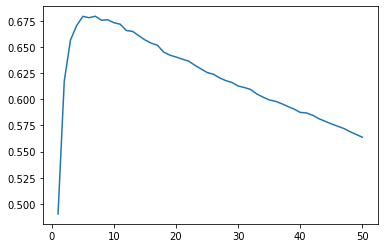

In [24]:
plt.plot(range(1, len(mean_scores)+1), mean_scores)

In [25]:
np.argmax(mean_scores)+1

7

In [26]:
#best
knn = KNeighborsRegressor(n_neighbors= 7)
knn.fit(X_train_50, y_train)
print('R-squared for train')
r2_train_knn = knn.score(X_train_50, y_train)
print(r2_train_knn)
print('R-squared for test')
r2_test_knn = knn.score(X_test_50, y_test)
print(r2_test_knn)
print('Mse for test')
mse_test_knn = mean_squared_error(y_test, knn.predict(X_test_50))
print(mse_test_knn)
print('Mse for train')
mse_train_knn = mean_squared_error(y_train, knn.predict(X_train_50))
print(mse_train_knn)
print('Mae for train')
mae_train_knn = mean_absolute_error(y_train, knn.predict(X_train_50))
print(mae_train_knn)
print('Mae for test')
mae_test_knn = mean_absolute_error(y_test, knn.predict(X_test_50))
print(mae_test_knn)

R-squared for train
0.7972913343414596
R-squared for test
0.7601465895543713
Mse for test
0.037869519997634694
Mse for train
0.03210580753858408
Mae for train
0.12618915039546388
Mae for test
0.13333643296205144


Decision Tree

In [27]:
param_tuning = {#"splitter":["best","random"],
            "max_depth" : [None, 1,3,4,5,6,7],
           "min_samples_leaf":[1,2,3,4,5],
           "min_weight_fraction_leaf":[0.0,0.1,0.2,0.3,0.4,0.5],
           "max_features":["auto","log2","sqrt",None],
           "max_leaf_nodes":[None,10,20,30,40,50]}

dt = DecisionTreeRegressor(random_state = 4)

gsearch = GridSearchCV(dt, param_grid=param_tuning, scoring='neg_mean_squared_error', cv=3, n_jobs =-1, verbose=3)

#gsearch.fit(X_train_50, y_train)
#gsearch.best_score_
#gsearch.best_estimator_

In [28]:
#with all features
ds = DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=6,
                      max_features='auto', max_leaf_nodes=30,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=5, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=4, splitter='best')
ds.fit(X_train, y_train)
print('R-squared for train')
print(ds.score(X_train, y_train))
print('R-squared for test')
print(ds.score(X_test, y_test))
print('Mse for test')
print(mean_squared_error(y_test, ds.predict(X_test)))
print('Mse for train')
print(mean_squared_error(y_train, ds.predict(X_train)))

R-squared for train
0.8526078286218269
R-squared for test
0.7394413227711891
Mse for test
0.04113859385839525
Mse for train
0.023344560389602906


In [29]:
#best
#with 50 most correlated features
dt = DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=50,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=4, splitter='best')
dt.fit(X_train_50, y_train)
print('R-squared for train')
r2_train_dt = dt.score(X_train_50, y_train)
print(r2_train_dt)
print('R-squared for test')
r2_test_dt = dt.score(X_test_50, y_test)
print(r2_test_dt)
print('Mse for test')
mse_test_dt = mean_squared_error(y_test, dt.predict(X_test_50))
print(mse_test_dt)
print('Mse for train')
mse_train_dt = mean_squared_error(y_train, dt.predict(X_train_50))
print(mse_train_dt)
print('Mae for train')
mae_train_dt = mean_absolute_error(y_train, dt.predict(X_train_50))
print(mae_train_dt)
print('Mae for test')
mae_test_dt = mean_absolute_error(y_test, dt.predict(X_test_50))
print(mae_test_dt)

R-squared for train
0.8864855126917512
R-squared for test
0.7538770912218664
Mse for test
0.03885938665009055
Mse for train
0.017978877570526453
Mae for train
0.1026046667333371
Mae for test
0.14663214354768633


In [30]:
#lasso
#with features from lasso
ds = DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=50,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=4, splitter='best')
ds.fit(X_train_lasso, y_train)
print('R-squared for train')
print(ds.score(X_train_lasso, y_train))
print('R-squared for test')
print(ds.score(X_test_lasso, y_test))
print('Mse for test')
print(mean_squared_error(y_test, ds.predict(X_test_lasso)))
print('Mse for train')
print(mean_squared_error(y_train, ds.predict(X_train_lasso)))

R-squared for train
0.8972091026978173
R-squared for test
0.7387115091588397
Mse for test
0.041253821284747326
Mse for train
0.016280432584275143


Random Forest

In [31]:
param_tuning = {
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [10, 50, 100, 200, 400, 600, 800, 1000]}

rf = RandomForestRegressor(random_state= 4)

gsearch = GridSearchCV(rf, param_grid=param_tuning, scoring='neg_mean_squared_error', cv=3, n_jobs = -1, verbose=1)

#gsearch.fit(X_train, y_train)
#gsearch.best_score_
#gsearch.best_estimator_

In [32]:
#best (not so different)
#with all features, chosen parameters
rf  = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=30, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=800, n_jobs=None, oob_score=False,
                      random_state=4, verbose=0, warm_start=False)
rf.fit(X_train, y_train)
print('R-squared for train')
r2_train_rf = rf.score(X_train, y_train)
print(r2_train_rf)
print('R-squared for test')
r2_test_rf = rf.score(X_test, y_test)
print(r2_test_rf)
print('Mse for test')
mse_test_rf = mean_squared_error(y_test, rf.predict(X_test))
print(mse_test_rf)
print('Mse for train')
mse_train_rf = mean_squared_error(y_train, rf.predict(X_train))
print(mse_train_rf)
print('Mae for train')
mae_train_rf = mean_absolute_error(y_train, rf.predict(X_train))
print(mae_train_rf)
print('Mae for test')
mae_test_rf = mean_absolute_error(y_test, rf.predict(X_test))
print(mae_test_rf)

R-squared for train
0.9811449772868712
R-squared for test
0.8925807832555003
Mse for test
0.016960001398680234
Mse for train
0.0029863337534028075
Mae for train
0.03686060018791969
Mae for test
0.08825304282415218


In [33]:
#with 50 most corr features, default parameters
rf  = RandomForestRegressor()
rf.fit(X_train_50, y_train)
print('R-squared for train')
print(rf.score(X_train_50, y_train))
print('R-squared for test')
print(rf.score(X_test_50, y_test))
print('Mse for test')
print(mean_squared_error(y_test, rf.predict(X_test_50)))
print('Mse for train')
print(mean_squared_error(y_train, rf.predict(X_train_50)))

R-squared for train
0.9784463235062847
R-squared for test
0.8723877796002225
Mse for test
0.02014819603103964
Mse for train
0.003413757310315421


In [34]:
#with all features, default parameters
rf  = RandomForestRegressor()
rf.fit(X_train, y_train)
print('R-squared for train')
print(rf.score(X_train, y_train))
print('R-squared for test')
print(rf.score(X_test, y_test))
print('Mse for test')
print(mean_squared_error(y_test, rf.predict(X_test)))
print('Mse for train')
print(mean_squared_error(y_train, rf.predict(X_train)))

R-squared for train
0.9801293126666764
R-squared for test
0.8918390144946939
Mse for test
0.017077116376819537
Mse for train
0.003147198769773932


XGBoost

In [35]:
param_tuning = {
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7, 10],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [100, 200, 500],
        'objective': ['reg:squarederror']
    }

xgb_model = XGBRegressor()

gsearch = GridSearchCV(estimator = xgb_model,
                      param_grid = param_tuning,                        
                      #scoring = 'neg_mean_absolute_error', #MAE
                      scoring = 'neg_mean_squared_error',  #MSE
                      cv = 5,
                      n_jobs = -1,
                      verbose = 1)

#gsearch.fit(X_train,y_train)  #runs 
#gsearch.best_params_
#gsearch.best_estimator_


In [36]:
#with 50 most corr features
xg = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=500,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.5, verbosity=1)
xg.fit(X_train_50, y_train)
print('R-squared for train')
print(xg.score(X_train_50, y_train))
print('R-squared for test')
print(xg.score(X_test_50, y_test))
print('Mse for test')
print(mean_squared_error(y_test, xg.predict(X_test_50)))
print('Mse for train')
print(mean_squared_error(y_train, xg.predict(X_train_50)))

R-squared for train
0.9848228054940954
R-squared for test
0.8850594634665118
Mse for test
0.018147513261148725
Mse for train
0.0024038246426180726


In [37]:
#best
#with all features
xg = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=500,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.5, verbosity=1)
xg.fit(X_train, y_train)
y_pred_xg = xg.predict(X_test)
print('R-squared for train')
r2_train_xg = xg.score(X_train, y_train)
print(r2_train_xg)
print('R-squared for test')
r2_test_xg = xg.score(X_test, y_test)
print(r2_test_xg)
print('Mse for test')
mse_test_xg = mean_squared_error(y_test, xg.predict(X_test))
print(mse_test_xg)
print('Mse for train')
mse_train_xg = mean_squared_error(y_train, xg.predict(X_train))
print(mse_train_xg)
print('Mae for train')
mae_train_xg = mean_absolute_error(y_train, xg.predict(X_train))
print(mae_train_xg)
print('Mae for test')
mae_test_xg = mean_absolute_error(y_test, xg.predict(X_test))
print(mae_test_xg)

R-squared for train
0.9914544455091051
R-squared for test
0.9178128220246966
Mse for test
0.012976213154953018
Mse for train
0.0013534790281601048
Mae for train
0.02877310344487455
Mae for test
0.08156759372053907


Comparison

In [38]:
table= pd.DataFrame(columns=["Method","R2 Train","MSE Train","MAE Train","R2 Test","MSE Test","MAE Test"])
table = table.append({"Method": "Linear Regression",
                      "R2 Train": r2_train_lr,
                      "MSE Train": mse_train_lr,
                      "MAE Train": mae_train_lr,
                      "R2 Test": r2_test_lr,
                      "MSE Test": mse_test_lr,
                      "MAE Test": mae_test_lr,},ignore_index = True)
table = table.append({"Method": "SVR",
                      "R2 Train": r2_train_svr,
                      "MSE Train": mse_train_svr,
                      "MAE Train": mae_train_svr,
                      "R2 Test": r2_test_svr,
                      "MSE Test": mse_test_svr,
                      "MAE Test": mae_test_svr,},ignore_index = True)
table = table.append({"Method": "Linear SVR",
                      "R2 Train": r2_train_lsvr,
                      "MSE Train": mse_train_lsvr,
                      "MAE Train": mae_train_lsvr,
                      "R2 Test": r2_test_lsvr,
                      "MSE Test": mse_test_lsvr,
                      "MAE Test": mae_test_lsvr,},ignore_index = True)
table = table.append({"Method": "KNN Regression",
                      "R2 Train": r2_train_knn,
                      "MSE Train": mse_train_knn,
                      "MAE Train": mae_train_knn,
                      "R2 Test": r2_test_knn,
                      "MSE Test": mse_test_knn,
                      "MAE Test": mae_test_knn,},ignore_index = True)
table = table.append({"Method": "Decision Tree Regression",
                      "R2 Train": r2_train_dt,
                      "MSE Train": mse_train_dt,
                      "MAE Train": mae_train_dt,
                      "R2 Test": r2_test_dt,
                      "MSE Test": mse_test_dt,
                      "MAE Test": mae_test_dt,},ignore_index = True)
table = table.append({"Method": "Random Forest Regression",
                      "R2 Train": r2_train_rf,
                      "MSE Train": mse_train_rf,
                      "MAE Train": mae_train_rf,
                      "R2 Test": r2_test_rf,
                      "MSE Test": mse_test_rf,
                      "MAE Test": mae_test_rf,},ignore_index = True)
table = table.append({"Method": "Ridge Regression",
                      "R2 Train": r2_train_ridge,
                      "MSE Train": mse_train_ridge,
                      "MAE Train": mae_train_ridge,
                      "R2 Test": r2_test_ridge,
                      "MSE Test": mse_test_ridge,
                      "MAE Test": mae_test_ridge,},ignore_index = True)
table = table.append({"Method": "Lasso Regression",
                      "R2 Train": r2_train_lasso,
                      "MSE Train": mse_train_lasso,
                      "MAE Train": mae_train_lasso,
                      "R2 Test": r2_test_lasso,
                      "MSE Test": mse_test_lasso,
                      "MAE Test": mae_test_lasso,},ignore_index = True)
table = table.append({"Method": "Extreme Gradient Boosting",
                      "R2 Train": r2_train_xg,
                      "MSE Train": mse_train_xg,
                      "MAE Train": mae_train_xg,
                      "R2 Test": r2_test_xg,
                      "MSE Test": mse_test_xg,
                      "MAE Test": mae_test_xg,},ignore_index = True)
table.sort_values("R2 Test", ascending = False)

,Method,R2 Train,MSE Train,MAE Train,R2 Test,MSE Test,MAE Test
1,SVR,0.913307,0.013731,0.080192,0.919179,0.012760,0.080077
8,Extreme Gradient Boosting,0.991454,0.001353,0.028773,0.917813,0.012976,0.081568
2,Linear SVR,0.822248,0.028153,0.090705,0.910835,0.014078,0.082843
0,Linear Regression,0.868954,0.020756,0.097827,0.908979,0.014371,0.090352
7,Lasso Regression,0.858160,0.022465,0.098730,0.907491,0.014606,0.088067
6,Ridge Regression,0.929706,0.011134,0.074759,0.906537,0.014757,0.081822
5,Random Forest Regression,0.981145,0.002986,0.036861,0.892581,0.016960,0.088253
3,KNN Regression,0.797291,0.032106,0.126189,0.760147,0.037870,0.133336
4,Decision Tree Regression,0.886486,0.017979,0.102605,0.753877,0.038859,0.146632


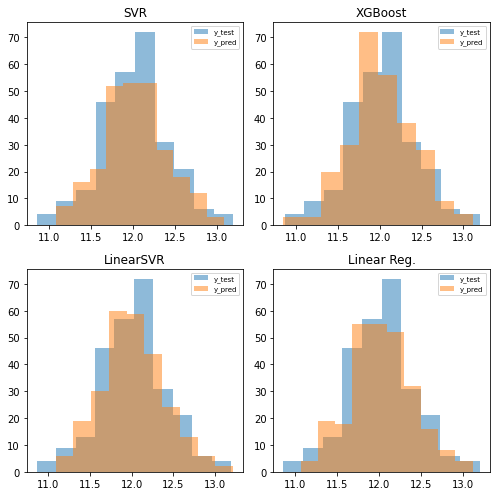

In [39]:
#Comparative histograms of log transformations of predicted and actual prices for the top 4 models: SVR, XGBoost, and LinearSVR, Linear Reg.
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(7, 7))

ax0.hist(y_test, alpha=0.5, label='y_test')
ax0.hist(y_pred_svr, alpha=0.5, label='y_pred')
ax0.legend(loc='upper right', prop={'size': 7})
ax0.set_title('SVR')

ax1.hist(y_test, alpha=0.5, label='y_test')
ax1.hist(y_pred_xg, alpha=0.5, label='y_pred')
ax1.legend(loc='upper right', prop={'size': 7})
ax1.set_title('XGBoost')

ax2.hist(y_test, alpha=0.5, label='y_test')
ax2.hist(y_pred_lsvr, alpha=0.5, label='y_pred')
ax2.legend(loc='upper right', prop={'size': 7})
ax2.set_title('LinearSVR')

ax3.hist(y_test, alpha=0.5, label='y_test')
ax3.hist(y_pred_lr, alpha=0.5, label='y_pred')
ax3.legend(loc='upper right', prop={'size': 7})
ax3.set_title('Linear Reg.')

fig.tight_layout()
plt.show()

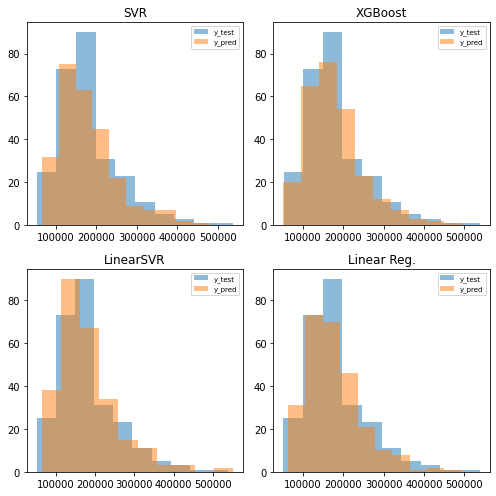

In [40]:
#Comparative histograms of predicted and actual prices for the top 4 models: SVR, XGBoost, and LinearSVR, Linear Reg.
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(7, 7))

ax0.hist(np.exp(y_test), alpha=0.5, label='y_test')
ax0.hist(np.exp(y_pred_svr), alpha=0.5, label='y_pred')
ax0.legend(loc='upper right', prop={'size': 7})
ax0.set_title('SVR')

ax1.hist(np.exp(y_test), alpha=0.5, label='y_test')
ax1.hist(np.exp(y_pred_xg), alpha=0.5, label='y_pred')
ax1.legend(loc='upper right', prop={'size': 7})
ax1.set_title('XGBoost')

ax2.hist(np.exp(y_test), alpha=0.5, label='y_test')
ax2.hist(np.exp(y_pred_lsvr), alpha=0.5, label='y_pred')
ax2.legend(loc='upper right', prop={'size': 7})
ax2.set_title('LinearSVR')

ax3.hist(np.exp(y_test), alpha=0.5, label='y_test')
ax3.hist(np.exp(y_pred_lr), alpha=0.5, label='y_pred')
ax3.legend(loc='upper right', prop={'size': 7})
ax3.set_title('Linear Reg.')

fig.tight_layout()
plt.show()